# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from utils import compute_scores, compute_confusion_matrix

pd.set_option("display.max_colwidth", 999)

/Users/sofiene.alouini/miniconda3/envs/maker-nlp/lib/python3.9/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Data loading

In [2]:
train_df = pd.read_csv("../data/train.csv").fillna("")
test_df = pd.read_csv("../data/test.csv").fillna("")

# Feature engineering

In [3]:
def relative_length_diff(df: pd.DataFrame) -> pd.Series:
    q1_nb_words = df["q1_text"].str.split().str.len()
    q2_nb_words = df["q2_text"].str.split().str.len()
    max_length = pd.concat([q1_nb_words, q2_nb_words], axis=1).max(axis=1)
    length_diff = (q1_nb_words - q2_nb_words).abs()
    return length_diff / max_length

def relative_nb_question_marks_diff(df: pd.DataFrame) -> pd.Series:
    q1_nb_question_marks = df["q1_text"].str.lower().str.count("\?")
    q2_nb_question_marks = df["q2_text"].str.lower().str.count("\?")
    max_nb_question_marks = pd.concat([q1_nb_question_marks, q2_nb_question_marks], axis=1).max(axis=1)
    nb_question_marks_diff = (q1_nb_question_marks - q2_nb_question_marks).abs()
    return nb_question_marks_diff / max_nb_question_marks

def common_words_ratio(df: pd.DataFrame) -> pd.Series:
    q1_words = df["q1_text"].str.split().map(set)
    q2_words = df["q2_text"].str.split().map(set)
    common_words_ratio = pd.DataFrame({"q1_words": q1_words, "q2_words": q2_words}).apply(
        lambda row: len(row["q1_words"].intersection(row["q2_words"])) / len(row["q1_words"].union(row["q2_words"])),
        axis=1
    )
    return common_words_ratio

def create_features(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "relative_length_diff": relative_length_diff(df),
        "relative_nb_question_marks_diff": relative_nb_question_marks_diff(df),
        "common_words_ratio": common_words_ratio(df)
    })

In [4]:
features = {
    "train": create_features(train_df),
    "test": create_features(test_df)
}

targets = {
    "train": train_df["is_duplicate"],
    "test": test_df["is_duplicate"]
}

# Model: Decision Tree

In [5]:
model = DecisionTreeClassifier(max_depth=3, class_weight={0: 1, 1: 1.5})

# TODO: fit the model 

DecisionTreeClassifier(class_weight={0: 1, 1: 1.5}, max_depth=3)

In [6]:
y_test_true = targets["test"]
y_test_pred = model.predict(features["test"].fillna(0))

In [7]:
compute_scores(y_test_true, y_test_pred)

{'Accuracy': '67.06%', 'Recall': '81.82%', 'Precision': '53.53%'}

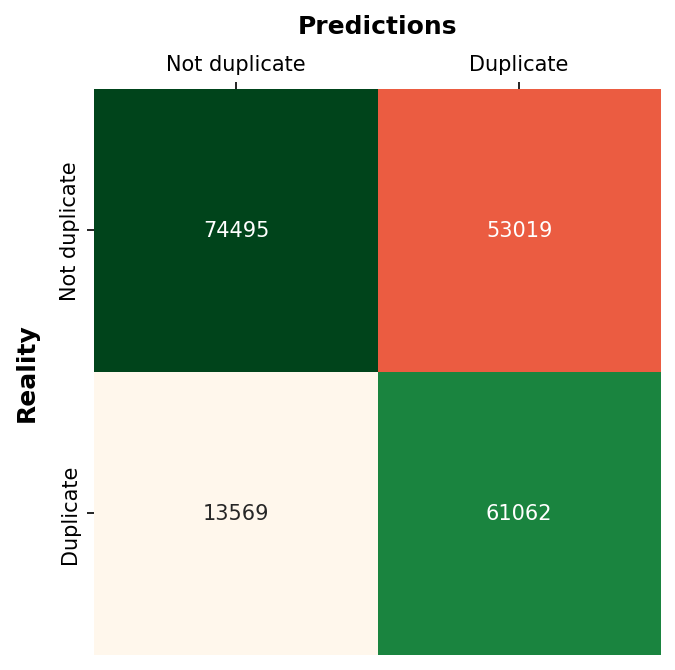

In [8]:
compute_confusion_matrix(y_test_true, y_test_pred, dpi=150)

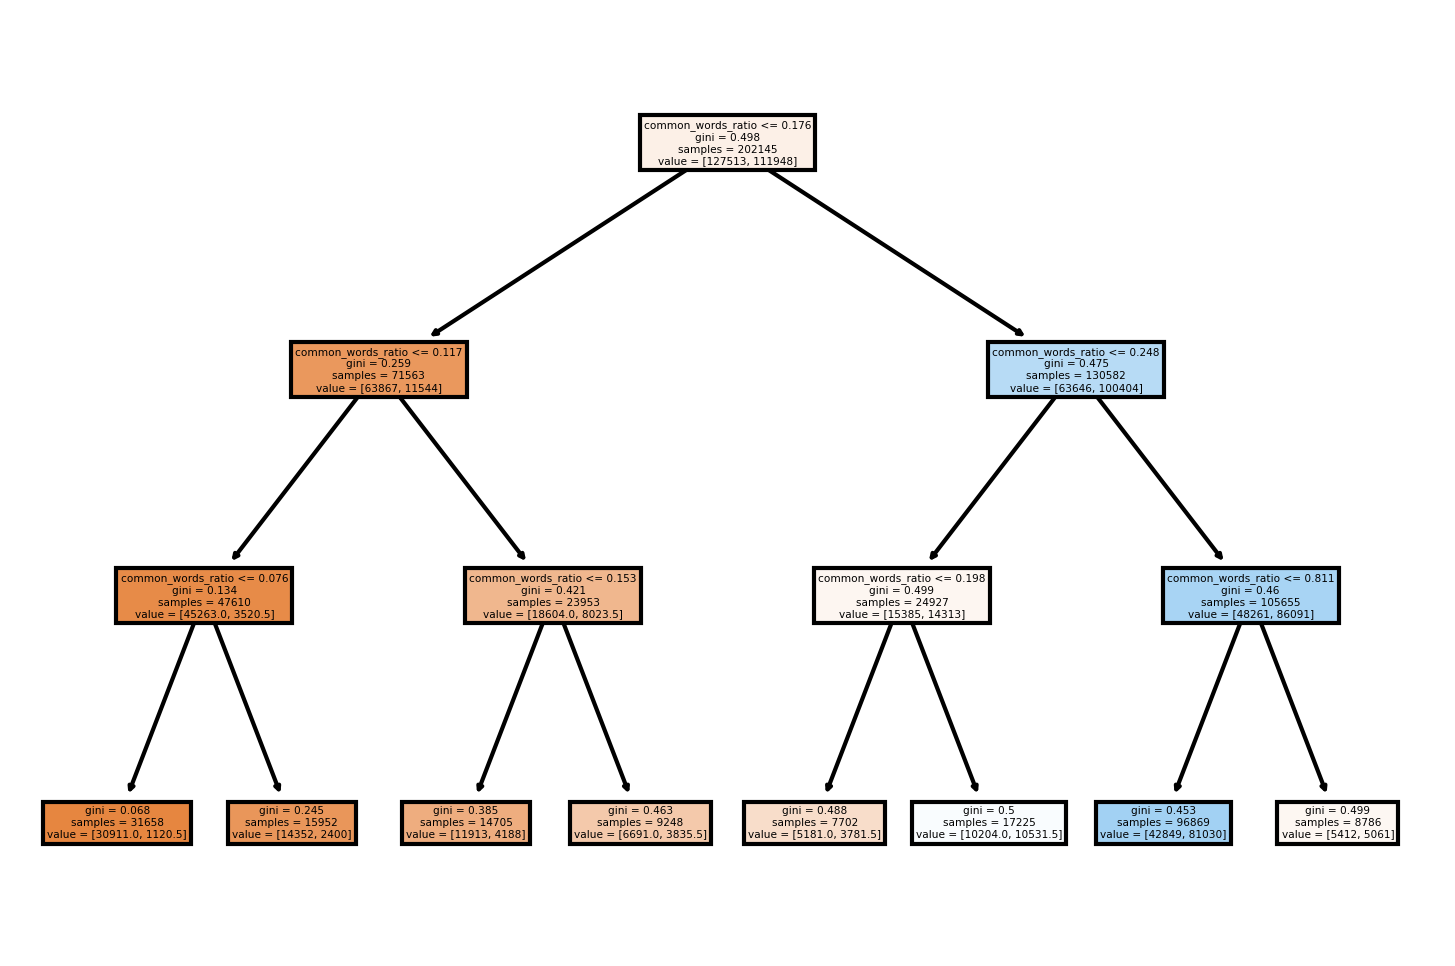

In [9]:
plt.figure(dpi=300)
plot_tree(model, filled=True, feature_names=model.feature_names_in_)
plt.show()

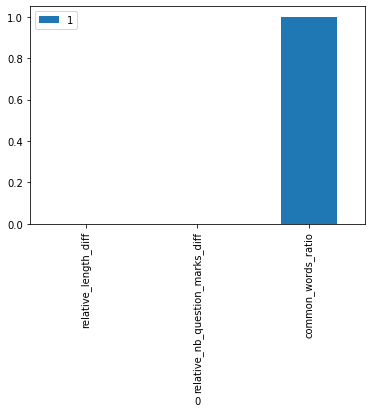

In [10]:
pd.DataFrame(
    list(
        zip(
            model.feature_names_in_,
            model.feature_importances_
        )
    )
).plot.bar(x=0, y=1)

plt.show()

# Error analysis

## False positives

The question pair **is not a duplicate** but the model **predicted a duplicate**.

In [11]:
test_df[(y_test_true == 0) & (y_test_pred == 1)][["q1_text", "q2_text"]].iloc[:15]

,q1_text,q2_text
5,How can I delete photos from my iPhone but keep them in iCloud?,How do I keep videos on iCloud after deleting them from my phone?
7,What is index?,What is index of movies?
10,What are some ambient artists worth listening to?,What song/music is worth listening to from start to finish?
11,How do I deal with my jealousy?,How do I deal with jealousy of other people?
16,What are the main cultural differences between South Korea and the USA?,What is the difference between rule and convention?
23,What do flowers do at night?,Why do flowers bloom at night?
25,What is the compound name for HBr?,What is the IUPAC name of this compound Cl O OH?
27,How much money does an Uber driver make in Miami Florida?,How much does a Uber driver make in Nampa ID?
28,What is feminist research?,What is a feminist?
29,What are the advantages and disadvantages of external recruitment?,What are the disadvantages of external recruitment?


## False negatives

The question pair **is a duplicate** but the model **predicted it wasn't**.

In [12]:
# TODO: display q1 and q2 text for false positive 

,q1_text,q2_text
15,Where I can buy Xanax with no prescription?,Is Xanax available without prescription?
19,Why CNN is so anti-Trump?,Is CNN biased against Trump?
33,Can I switch jobs when on ICT tier 2 to contract or permanent role with a different employer in the UK? What is the process?,Can I switch my job freely if I work under Tier 2 in UK?
38,What percentage of Jews are atheists?,What percentage of Israeli Jews are atheists?
65,What is the best way to make more money?,What is the best way to to make money?
116,How can I gain height at age 20?,Is there any way to increase height after age of 20?
123,"Can a gas leak kill you by breathing it in? I know it can cause an explosion but can it kill you just by being around it? If it fills up your, house?",Can a gas leak kill you by breathing it in? I know it can cause an explosion but can it kill you just by being around it? If it fills up your house?
125,Why should I not vote for Donald Trump?,Why should I not vote for Trump?
126,Will there be a nuclear war between India and Pakistan?,What will happen if India and Pakistan gets into war and who will win?
131,Why Modi is putting a ban on 500 and 1000 notes?,Why did Modi scrap Rs 500 & Rs 1000 notes? And what's the reason for the sudden introduction of the 2000 rupee note?
